In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from PIL import Image


from clone_data import *

# Load Dataset

In [15]:
# read the dataframe
df = pd.read_csv('dog_captions.csv')
df

,caption,image,filename,path
0,a woman walks her dog on the beach .,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_0.jpg,images/image_0.jpg
1,"female puppies for person is animal , person i...",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_1.jpg,images/image_1.jpg
2,we 're spending holiday with our dogs this yea...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_2.jpg,images/image_2.jpg
3,snow was lingering for this person and her dog...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_3.jpg,images/image_3.jpg
4,this came up on my facebook .,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_4.jpg,images/image_4.jpg
...,...,...,...,...
12527,a pug from animal with dislocated legs cools o...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_12527.jpg,images/image_12527.jpg
12528,chihuahua dog dressed up as a turkey royalty -...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_12528.jpg,images/image_12528.jpg
12529,"rocket , my black cocker spaniel bouncing in a...",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_12529.jpg,images/image_12529.jpg
12530,the author argues that wolves are an impressiv...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_12530.jpg,images/image_12530.jpg


## Split Dataset

In [16]:
# split
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [17]:
train_df.shape, val_df.shape, test_df.shape

((9022, 4), (2507, 4), (1003, 4))

## Split Datasets Creation

In [18]:
from datasets import DatasetDict, Dataset

train_dataset = Dataset.from_pandas(train_df)
train_dataset

/media/SSD_2TB/msamprovalaki_software/anaconda3/envs/torch_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['caption', 'image', 'filename', 'path', '__index_level_0__'],
    num_rows: 9022
})

In [19]:
validation_data = Dataset.from_pandas(val_df)
validation_data

Dataset({
    features: ['caption', 'image', 'filename', 'path', '__index_level_0__'],
    num_rows: 2507
})

In [20]:
train_dataset[0]

{'caption': 'introducing your new cat to your dog .',
 'image': '{\'bytes\': b\'\\xff\\xd8\\xff\\xe0\\x00\\x10JFIF\\x00\\x01\\x01\\x00\\x00\\x01\\x00\\x01\\x00\\x00\\xff\\xdb\\x00C\\x00\\x08\\x06\\x06\\x07\\x06\\x05\\x08\\x07\\x07\\x07\\t\\t\\x08\\n\\x0c\\x14\\r\\x0c\\x0b\\x0b\\x0c\\x19\\x12\\x13\\x0f\\x14\\x1d\\x1a\\x1f\\x1e\\x1d\\x1a\\x1c\\x1c $.\\\' ",#\\x1c\\x1c(7),01444\\x1f\\\'9=82<.342\\xff\\xdb\\x00C\\x01\\x08\\t\\t\\x0c\\x0b\\x0c\\x18\\r\\r\\x182!\\x1c!22222222222222222222222222222222222222222222222222\\xff\\xc0\\x00\\x11\\x08\\x02\\x00\\x01U\\x03\\x01"\\x00\\x02\\x11\\x01\\x03\\x11\\x01\\xff\\xc4\\x00\\x1f\\x00\\x00\\x01\\x05\\x01\\x01\\x01\\x01\\x01\\x01\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x01\\x02\\x03\\x04\\x05\\x06\\x07\\x08\\t\\n\\x0b\\xff\\xc4\\x00\\xb5\\x10\\x00\\x02\\x01\\x03\\x03\\x02\\x04\\x03\\x05\\x05\\x04\\x04\\x00\\x00\\x01}\\x01\\x02\\x03\\x00\\x04\\x11\\x05\\x12!1A\\x06\\x13Qa\\x07"q\\x142\\x81\\x91\\xa1\\x08#B\\xb1\\xc1\\x15R\\xd1\\xf0$3br\\x82\\t\\n\\x1

## Load ViT-GPT2 Model

In [21]:
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)

In [22]:
cache_dir = '/home/msamprovalaki/captioning/cache_dir'

In [23]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor

image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decode_model = "gpt2"

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    image_encoder_model, text_decode_model, cache_dir=cache_dir)


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

In [24]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [26]:
feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model, cache_dir=cache_dir)
# text tokenizer
tokenizer = AutoTokenizer.from_pretrained(text_decode_model, cache_dir=cache_dir)

/media/SSD_2TB/msamprovalaki_software/anaconda3/envs/torch_gpu/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [27]:
def tokenize_captions(captions, max_target_length):
    """Run tokenization on captions."""
    labels = tokenizer(captions, 
                      padding="max_length", 
                      max_length=max_target_length).input_ids

    return labels

In [28]:
# GPT2 only has bos/eos tokens but not decoder_start/pad tokens
tokenizer.pad_token = tokenizer.eos_token

# update the model config
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [29]:
output_dir = "vit-gpt-model"
model.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('vit-gpt-model/tokenizer_config.json',
 'vit-gpt-model/special_tokens_map.json',
 'vit-gpt-model/vocab.json',
 'vit-gpt-model/merges.txt',
 'vit-gpt-model/added_tokens.json',
 'vit-gpt-model/tokenizer.json')

In [30]:
# image preprocessing step
def extract_features(image_paths, check_image=True):
    
    model_inputs = {}

    if check_image:
        images = []
        to_keep = []
        for image_file in image_paths:
            try:
                img = Image.open(image_file)
                if img.mode == 'L':  # Check if image is grayscale
                    img = img.convert('RGB')  # Convert to RGB
                images.append(img)
                to_keep.append(True)
            except Exception:
                to_keep.append(False)
    else:
        images = [Image.open(image_file) for image_file in image_paths]

    encoder_inputs = feature_extractor(images=images, return_tensors="np")

    return encoder_inputs.pixel_values


In [31]:
def preprocessing(examples, max_target_length, check_image = True):
    """Run tokenization + image feature extraction"""
    image_paths = examples['path'] 
    captions = examples['caption']    
    
    model_inputs = {}
    # This contains image path column
    model_inputs['labels'] = tokenize_captions(captions, max_target_length)
    model_inputs['pixel_values'] = extract_features(image_paths, check_image=check_image)

    return model_inputs

In [32]:
# in ds add both DatasetDict
ds = DatasetDict({'train': train_dataset, 'validation': validation_data})
ds

DatasetDict({
    train: Dataset({
        features: ['caption', 'image', 'filename', 'path', '__index_level_0__'],
        num_rows: 9022
    })
    validation: Dataset({
        features: ['caption', 'image', 'filename', 'path', '__index_level_0__'],
        num_rows: 2507
    })
})

In [33]:
processed_dataset = ds.map(
    function=preprocessing,
    batched=True,
    fn_kwargs={"max_target_length": 128},
    remove_columns=ds['train'].column_names
)

Map: 100%|██████████| 2507/2507 [00:14<00:00, 173.07 examples/s]


In [34]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 9022
    })
    validation: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 2507
    })
})

## Training

In [37]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    output_dir=output_dir + "/image-captioning-output",
)

/media/SSD_2TB/msamprovalaki_software/anaconda3/envs/torch_gpu/lib/python3.12/site-packages/transformers/training_args.py:1463: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [38]:
import evaluate
metric = evaluate.load("rouge")

In [39]:
ignore_pad_token_for_loss = True


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels,
                            use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [40]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['validation'],
    data_collator=default_data_collator,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [41]:
# torch.cuda.empty_cache()

In [42]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,0.309600,0.301685,22.575000,5.878900,20.587100,20.599500,8.397686
2,0.254800,0.294141,24.280600,6.663300,22.150700,22.133600,8.232948
3,0.205300,0.302464,24.535900,6.828200,22.236200,22.218100,8.836059


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/media/SSD_2TB/msamprovalaki_software/anaconda3/envs/torch_gpu/lib/python3.12/site-packages/transformers/generation/utils.py:1156: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain rel

TrainOutput(global_step=13533, training_loss=0.2651402813750695, metrics={'train_runtime': 5791.7654, 'train_samples_per_second': 4.673, 'train_steps_per_second': 2.337, 'total_flos': 4.884435677057384e+18, 'train_loss': 0.2651402813750695, 'epoch': 3.0})

In [43]:
trainer.save_model("/home/msamprovalaki/captioning/vit-gpt-model/image-captioning-output")
tokenizer.save_pretrained("/home/msamprovalaki/captioning/vit-gpt-model/image-captioning-output")
print("Model saved successfully")

Model saved successfully


# Evaluate in Valid Data

In [44]:
cache_dir

'/home/msamprovalaki/captioning/cache_dir'

In [46]:
# load the model
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor


model = VisionEncoderDecoderModel.from_pretrained("/home/msamprovalaki/captioning/vit-gpt-model/image-captioning-output", cache_dir=cache_dir)
tokenizer = AutoTokenizer.from_pretrained("/home/msamprovalaki/captioning/vit-gpt-model/image-captioning-output", cache_dir=cache_dir)
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k", cache_dir=cache_dir)

/media/SSD_2TB/msamprovalaki_software/anaconda3/envs/torch_gpu/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [49]:
image_path = validation_data['path'][4]
image_path

'images/image_10475.jpg'

In [50]:
from transformers import pipeline
#processor
image_encoder_model = "google/vit-base-patch16-224-in21k"

In [51]:
image_name = validation_data['filename'][4]
image_name

'image_10475.jpg'

In [52]:
from transformers import pipeline, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("/home/msamprovalaki/captioning/vit-gpt-model/image-captioning-output")

image_captioner = pipeline(
    "image-to-text",
    model="/home/msamprovalaki/captioning/vit-gpt-model/image-captioning-output",
    tokenizer=tokenizer,
    feature_extractor=image_encoder_model,
    device=0 if torch.cuda.is_available() else -1
)


/media/SSD_2TB/msamprovalaki_software/anaconda3/envs/torch_gpu/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [53]:
def pil_image(image_path):
    return Image.open(image_path)

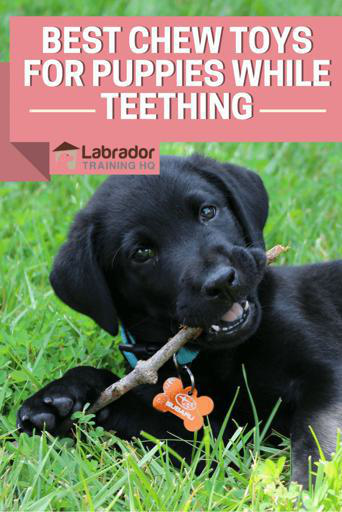

In [54]:
pil_image(image_path)

In [55]:
image = pil_image(image_path)

# Generate caption
caption = image_captioner(image)
caption

/media/SSD_2TB/msamprovalaki_software/anaconda3/envs/torch_gpu/lib/python3.12/site-packages/transformers/generation/utils.py:1156: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'a dog is the only thing on earth that loves you more than he loves himself'}]

In [61]:
from textwrap import wrap


def plot_images(images, actual_captions, predicted_captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        actual_caption = actual_captions[i]
        predicted_caption = predicted_captions[i]
        
        # Format captions
        actual_caption = "\n".join(wrap(actual_caption, 12))
        predicted_caption = "\n".join(wrap(predicted_caption, 12))
        
        # Title includes both actual and predicted captions
        plt.title(f"Actual:\n{actual_caption}\n\nPredicted:\n{predicted_caption}")
        
        plt.imshow(images[i])
        plt.axis("off")


In [62]:
# pip install wrap

/media/SSD_2TB/msamprovalaki_software/anaconda3/envs/torch_gpu/lib/python3.12/site-packages/transformers/generation/utils.py:1156: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


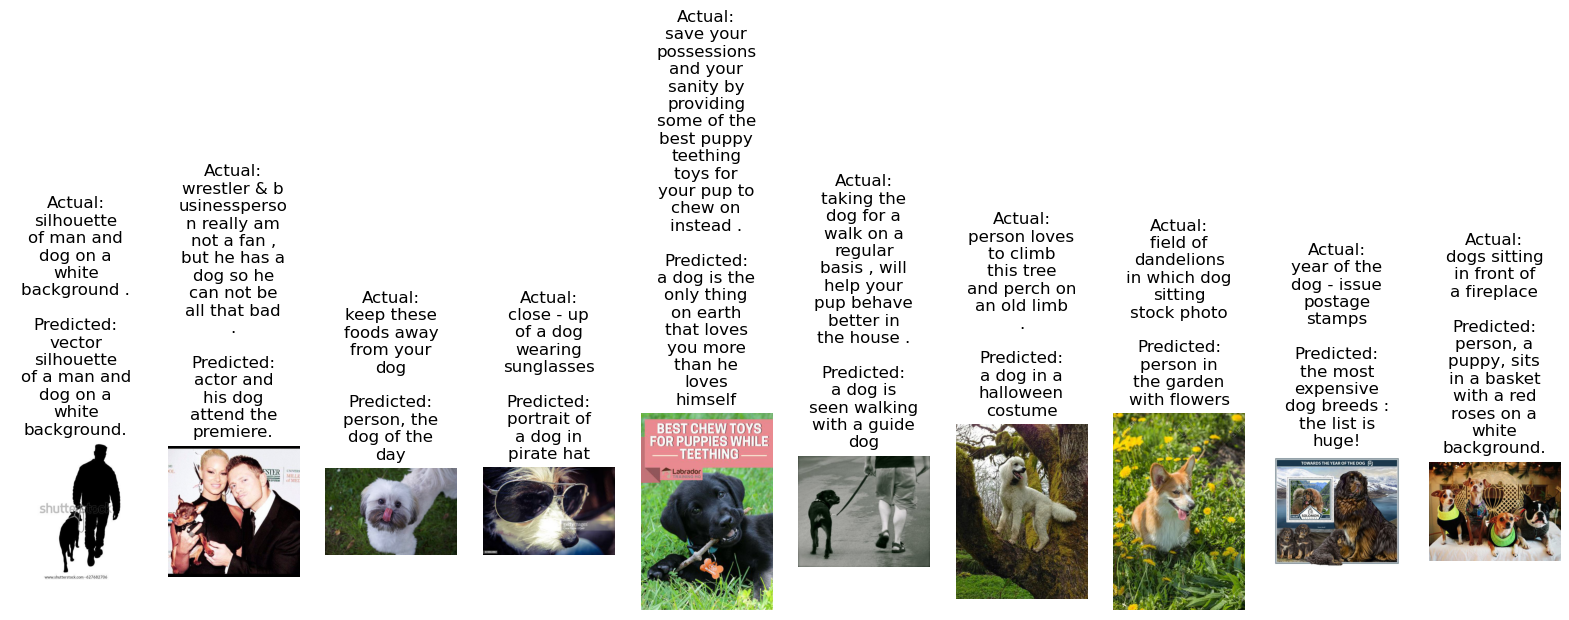

In [63]:
# Select 5 first images
sample_images = validation_data['path'][:10]
sample_actual_captions = validation_data['caption'][:10]   

# generate captions
sample_predicted_captions = [image_captioner(image_path)[0]['generated_text'] for image_path in sample_images]

# Load the images
sample_images = [pil_image(image_path) for image_path in sample_images]

# Plot the images with their actual and predicted captions
plot_images(sample_images, sample_actual_captions, sample_predicted_captions)

In [64]:
def captions_generation(image_paths):
    captions = []
    for image_path in image_paths:
        image = pil_image(image_path)
        caption = image_captioner(image)[0]['generated_text']
        captions.append(caption)
    return captions


In [65]:
image_paths = validation_data['path'][:5]
captions = captions_generation(image_paths)
captions

['vector silhouette of a man and dog on a white background.',
 'actor and his dog attend the premiere.',
 'person, the dog of the day',
 'portrait of a dog in pirate hat',
 'a dog is the only thing on earth that loves you more than he loves himself']

In [68]:
valid_data = pd.DataFrame(validation_data)
valid_data

,caption,image,filename,path,__index_level_0__
0,silhouette of man and dog on a white background .,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_11654.jpg,images/image_11654.jpg,11654
1,wrestler & businessperson really am not a fan ...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_2984.jpg,images/image_2984.jpg,2984
2,keep these foods away from your dog,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_9575.jpg,images/image_9575.jpg,9575
3,close - up of a dog wearing sunglasses,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_9927.jpg,images/image_9927.jpg,9927
4,save your possessions and your sanity by provi...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_10475.jpg,images/image_10475.jpg,10475
...,...,...,...,...,...
2502,a bad hair day made beautiful for this poodle !,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_1584.jpg,images/image_1584.jpg,1584
2503,"four of my very favorite things : dogs , men ,...",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_2666.jpg,images/image_2666.jpg,2666
2504,veterinary students wash a dog .,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_8745.jpg,images/image_8745.jpg,8745
2505,the most adorable relationship between a dog a...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_10687.jpg,images/image_10687.jpg,10687


In [69]:
# keep only path,caption, filename
valid_data = valid_data[['filename', 'caption', 'path']]

In [70]:
valid_data['generated_caption'] = valid_data['path'].apply(lambda x: image_captioner(x)[0]['generated_text'])

/media/SSD_2TB/msamprovalaki_software/anaconda3/envs/torch_gpu/lib/python3.12/site-packages/transformers/generation/utils.py:1156: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/tmp/ipykernel_31111/1470523056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['generated_caption'] = valid_data['path'].apply(lambda x: image_captioner(x)[0]['generated_text'])


In [71]:
valid_data['generated_caption']

0       vector silhouette of a man and dog on a white ...
1                  actor and his dog attend the premiere.
2                              person, the dog of the day
3                         portrait of a dog in pirate hat
4       a dog is the only thing on earth that loves yo...
                              ...                        
2502    person, a rescue dog, was rescued from a flood...
2503                           person, the dog of the day
2504    person, a service dog, is shown here with her ...
2505                           person with a flower crown
2506                                   person in the snow
Name: generated_caption, Length: 2507, dtype: object

In [72]:
gold_captions = valid_data[['path', 'caption']]
predicted_captions = valid_data[['path', 'generated_caption']]

In [73]:
gold_captions

,path,caption
0,images/image_11654.jpg,silhouette of man and dog on a white background .
1,images/image_2984.jpg,wrestler & businessperson really am not a fan ...
2,images/image_9575.jpg,keep these foods away from your dog
3,images/image_9927.jpg,close - up of a dog wearing sunglasses
4,images/image_10475.jpg,save your possessions and your sanity by provi...
...,...,...
2502,images/image_1584.jpg,a bad hair day made beautiful for this poodle !
2503,images/image_2666.jpg,"four of my very favorite things : dogs , men ,..."
2504,images/image_8745.jpg,veterinary students wash a dog .
2505,images/image_10687.jpg,the most adorable relationship between a dog a...


In [79]:
# save
gold_captions.to_csv('results/valid_gold_captions.csv', sep='|', header = False, index = False)

In [80]:
predicted_captions.to_csv('results/valid_predicted_captions.csv', sep='|', header = False, index = False)

In [74]:
merged_captions = pd.merge(gold_captions, predicted_captions, on='path')
merged_captions


,path,caption,generated_caption
0,images/image_11654.jpg,silhouette of man and dog on a white background .,vector silhouette of a man and dog on a white ...
1,images/image_2984.jpg,wrestler & businessperson really am not a fan ...,actor and his dog attend the premiere.
2,images/image_9575.jpg,keep these foods away from your dog,"person, the dog of the day"
3,images/image_9927.jpg,close - up of a dog wearing sunglasses,portrait of a dog in pirate hat
4,images/image_10475.jpg,save your possessions and your sanity by provi...,a dog is the only thing on earth that loves yo...
...,...,...,...
2502,images/image_1584.jpg,a bad hair day made beautiful for this poodle !,"person, a rescue dog, was rescued from a flood..."
2503,images/image_2666.jpg,"four of my very favorite things : dogs , men ,...","person, the dog of the day"
2504,images/image_8745.jpg,veterinary students wash a dog .,"person, a service dog, is shown here with her ..."
2505,images/image_10687.jpg,the most adorable relationship between a dog a...,person with a flower crown


In [75]:
# save
valid_data.to_csv('results/valid_data.csv', index=False)

| Dataset  |BertScore | Rouge    |
|----------|----------|----------|
| valid    | 59.69    | 22.74    |
<!-- | Data     | Data     | Data     |
| Row 2,   | Row 2,   | Row 2,   |
| Data     | Data     | Data     |
| Row 3,   | Row 3,   | Row 3,   |
| Data     | Data     | Data     | -->


# Inference in Test Data

In [83]:
test_data = Dataset.from_pandas(test_df)
test_data

Dataset({
    features: ['caption', 'image', 'filename', 'path', '__index_level_0__'],
    num_rows: 1003
})

In [84]:
test_data[0]

{'caption': 'person told me that this is hergo to brand for her dog',
 'image': '{\'bytes\': b\'\\xff\\xd8\\xff\\xe0\\x00\\x10JFIF\\x00\\x01\\x01\\x00\\x00\\x01\\x00\\x01\\x00\\x00\\xff\\xdb\\x00C\\x00\\x08\\x06\\x06\\x07\\x06\\x05\\x08\\x07\\x07\\x07\\t\\t\\x08\\n\\x0c\\x14\\r\\x0c\\x0b\\x0b\\x0c\\x19\\x12\\x13\\x0f\\x14\\x1d\\x1a\\x1f\\x1e\\x1d\\x1a\\x1c\\x1c $.\\\' ",#\\x1c\\x1c(7),01444\\x1f\\\'9=82<.342\\xff\\xdb\\x00C\\x01\\x08\\t\\t\\x0c\\x0b\\x0c\\x18\\r\\r\\x182!\\x1c!22222222222222222222222222222222222222222222222222\\xff\\xc0\\x00\\x11\\x08\\x02\\x00\\x01\\x97\\x03\\x01"\\x00\\x02\\x11\\x01\\x03\\x11\\x01\\xff\\xc4\\x00\\x1f\\x00\\x00\\x01\\x05\\x01\\x01\\x01\\x01\\x01\\x01\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x01\\x02\\x03\\x04\\x05\\x06\\x07\\x08\\t\\n\\x0b\\xff\\xc4\\x00\\xb5\\x10\\x00\\x02\\x01\\x03\\x03\\x02\\x04\\x03\\x05\\x05\\x04\\x04\\x00\\x00\\x01}\\x01\\x02\\x03\\x00\\x04\\x11\\x05\\x12!1A\\x06\\x13Qa\\x07"q\\x142\\x81\\x91\\xa1\\x08#B\\xb1\\xc1\\x15R\\xd1\\xf

In [85]:
# load the model
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor


model = VisionEncoderDecoderModel.from_pretrained("/home/msamprovalaki/captioning/vit-gpt-model/image-captioning-output", cache_dir=cache_dir)
tokenizer = AutoTokenizer.from_pretrained("/home/msamprovalaki/captioning/vit-gpt-model/image-captioning-output", cache_dir=cache_dir)
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k", cache_dir=cache_dir)

/media/SSD_2TB/msamprovalaki_software/anaconda3/envs/torch_gpu/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [86]:
image_path = test_data['path'][4]
image_path

'images/image_3507.jpg'

In [87]:
from transformers import pipeline
#processor
image_encoder_model = "google/vit-base-patch16-224-in21k"

In [88]:
image_name = test_data['filename'][4]
image_name

'image_3507.jpg'

In [89]:
from transformers import pipeline, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("/home/msamprovalaki/captioning/vit-gpt-model/image-captioning-output")

image_captioner = pipeline(
    "image-to-text",
    model="/home/msamprovalaki/captioning/vit-gpt-model/image-captioning-output",
    tokenizer=tokenizer,
    feature_extractor=image_encoder_model,
    device=0 if torch.cuda.is_available() else -1
)

/media/SSD_2TB/msamprovalaki_software/anaconda3/envs/torch_gpu/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [90]:
def pil_image(image_path):
    return Image.open(image_path)

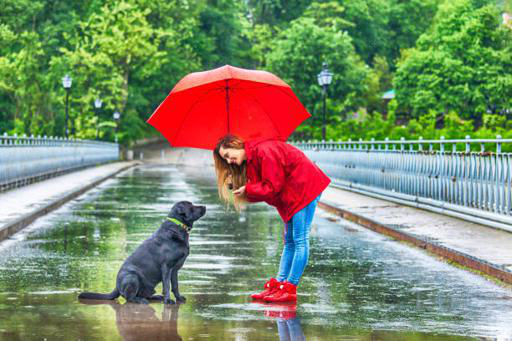

In [91]:
pil_image(image_path)

In [92]:
image = pil_image(image_path)

# Generate caption
caption = image_captioner(image)
caption

/media/SSD_2TB/msamprovalaki_software/anaconda3/envs/torch_gpu/lib/python3.12/site-packages/transformers/generation/utils.py:1156: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'a woman walks her dog in the park'}]

In [93]:
def captions_generation(image_paths):
    captions = []
    for image_path in image_paths:
        image = pil_image(image_path)
        caption = image_captioner(image)[0]['generated_text']
        captions.append(caption)
    return captions

In [94]:
test_dataset = pd.DataFrame(test_data)
test_dataset

,caption,image,filename,path,__index_level_0__
0,person told me that this is hergo to brand for...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_2121.jpg,images/image_2121.jpg,2121
1,a dog peering curiously at the camera .,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_11309.jpg,images/image_11309.jpg,11309
2,there was a bit of fun when a cheeky dog inter...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_2654.jpg,images/image_2654.jpg,2654
3,"arms manufacturers business , the dog of the day",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_705.jpg,images/image_705.jpg,705
4,beautiful girl with umbrella talking to a dog,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_3507.jpg,images/image_3507.jpg,3507
...,...,...,...,...,...
998,"puppy , and a rabbit in front of white background",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_2610.jpg,images/image_2610.jpg,2610
999,woman with dog and holding a tablet,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_9213.jpg,images/image_9213.jpg,9213
1000,the jury 's still out on whether a hug from an...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_12486.jpg,images/image_12486.jpg,12486
1001,wait til you 've seen the fight in our dog,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,image_5088.jpg,images/image_5088.jpg,5088


In [95]:
test_dataset = test_dataset[['filename', 'caption', 'path']]


In [96]:
test_dataset['generated_caption'] = test_dataset['path'].apply(lambda x: image_captioner(x)[0]['generated_text'])

/media/SSD_2TB/msamprovalaki_software/anaconda3/envs/torch_gpu/lib/python3.12/site-packages/transformers/generation/utils.py:1156: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/tmp/ipykernel_31111/998425880.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['generated_caption'] = test_dataset['path'].apply(lambda x: image_captioner(x)[0]['generated_text'])


In [99]:
test_dataset['generated_caption'] 

0       a dog is the only thing on earth that loves yo...
1                              puppy sitting in the grass
2                   a dog is seen during a demonstration.
3                                     a dog in the garden
4                       a woman walks her dog in the park
                              ...                        
998          puppy sitting in front of a white background
999                       a girl with her dog on the lawn
1000       animal, sitting in front of a white background
1001                 the difference between cats and dogs
1002                          animal sitting in the grass
Name: generated_caption, Length: 1003, dtype: object

In [100]:
gold_captions = test_dataset[['path', 'caption']]
predicted_captions = test_dataset[['path', 'generated_caption']]

In [101]:
# save
gold_captions.to_csv('results/test_gold_captions.csv', sep='|', header = False, index = False)
predicted_captions.to_csv('results/test_predicted_captions.csv', sep='|', header = False, index = False)

In [102]:
test_dataset.to_csv('results/test_dataset.csv', index=False)

| Dataset  |BertScore | Rouge    |
|----------|----------|----------|
| Test    | 59.79    | 23.18   |